# **2502014210 - Eleanor Maritsa Maharani**

Dataset : AMZN dan CSCO

# **No. 2A - CSCO**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.activations import relu
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout
from sklearn.metrics import make_scorer


In [ ]:
# Load the data
data = pd.read_csv("/CSCO.csv")

In [ ]:
# Mengambil kolom Close sebagai target variabel
target = data['Close'].values

In [ ]:
# Membuat list untuk menyimpan input dan output
input_data = []
output_data = []

Disini saya akan memisahkan data time series menjadi input dan output. Input atau window size adalah jumlah langkah waktu dari data historis yang digunakan untuk memprediksi. Window size saya inisialisasi 5, karena saya mau mengambil dari hari senin sampai dengan hari jumat. Output atau horizon adalah jumlah langkah waktu untuk memprediksi ke masa depan. Horizon saya inisialisasi 5 karena dari hari senin-jumat.

In [ ]:
# Mendefinisikan window size dan horizon
window_size = 5
horizon = 5

In [ ]:
# Memisahkan data menjadi input dan output
for i in range(len(target) - window_size - horizon + 1):
    input_data.append(target[i:i+window_size])
    output_data.append(target[i+window_size:i+window_size+horizon])

In [ ]:
# Mengubah input dan output menjadi numpy array
input_data = np.array(input_data)
output_data = np.array(output_data)

In [ ]:
print("input data:",input_data)
print("output data:",output_data)

input data: [[ 0.07725695  0.07986111  0.078125    0.07899305  0.07855903]
 [ 0.07986111  0.078125    0.07899305  0.07855903  0.07638889]
 [ 0.078125    0.07899305  0.07855903  0.07638889  0.078125  ]
 ...
 [35.5        37.11999893 37.70999908 35.59999847 34.59999847]
 [37.11999893 37.70999908 35.59999847 34.59999847 38.59999847]
 [37.70999908 35.59999847 34.59999847 38.59999847 37.66999817]]
output data: [[ 0.07638889  0.078125    0.08072916  0.07986111  0.08072916]
 [ 0.078125    0.08072916  0.07986111  0.08072916  0.07986111]
 [ 0.08072916  0.07986111  0.08072916  0.07986111  0.07986111]
 ...
 [38.59999847 37.66999817 40.58000183 38.81999969 40.31999969]
 [37.66999817 40.58000183 38.81999969 40.31999969 39.31000137]
 [40.58000183 38.81999969 40.31999969 39.31000137 38.33000183]]


pisahkan dataset menjadi 80% training set, 10% validation set dan 10% test set

In [ ]:
# Memisahkan dataset menjadi training set, validation set, dan test set
X_train, X_temp, y_train, y_temp = train_test_split(input_data, output_data, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [ ]:
# Cetak ukuran setiap set
print("Ukuran Training Set:", X_train.shape)
print("Ukuran Validation Set:", X_val.shape)
print("Ukuran Test Set:", X_test.shape)

Ukuran Training Set: (6064, 5)
Ukuran Validation Set: (758, 5)
Ukuran Test Set: (758, 5)


# **No. 2B - CSCO**

Membuat arsitektur baseline sesuai dengan gambar arsitektur Transformer
for Stocks

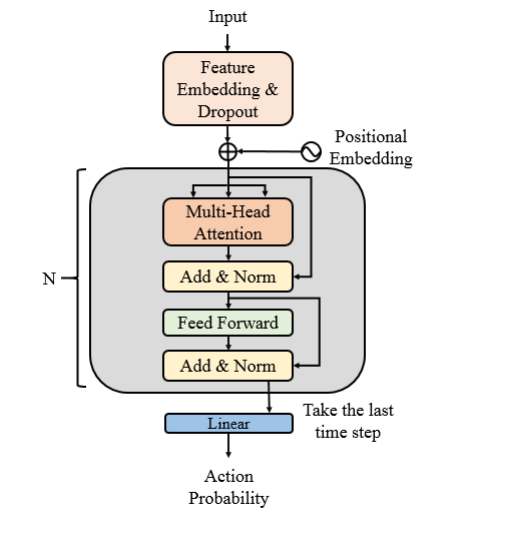

Bagian FEED FORWARD menggunakan satu layer Conv1D saja dengan Activation function menggunakan ReLU dan bagian node Perceptron pada output
disesuaikan dengan horizon datanya

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, LayerNormalization, Add

def create_transformer_model(window_size, horizon):
    # Input layer
    inputs = Input(shape=(window_size, 1))

    # Convolutional layer
    conv = Conv1D(filters=64, kernel_size=3, padding='causal')(inputs)
    conv = Activation('relu')(conv)

    # Transformer blocks
    num_blocks = 4
    d_model = 64
    d_ff = 128

    for _ in range(num_blocks):
        # Multi-Head Attention
        attention = tf.keras.layers.MultiHeadAttention(
            num_heads=8, key_dim=d_model, dropout=0.1)(conv, conv)
        attention = LayerNormalization()(Add()([conv, attention]))

        # Feed Forward layer
        feed_forward = Conv1D(filters=d_ff, kernel_size=1)(attention)
        feed_forward = Activation('relu')(feed_forward)
        feed_forward = Conv1D(filters=d_model, kernel_size=1)(feed_forward)
        feed_forward = LayerNormalization()(Add()([attention, feed_forward]))

        # Skip connection
        conv = feed_forward

    # Perceptron output layer
    perceptron = Dense(units=horizon)(conv)

    # Output layer
    output = Activation('linear')(perceptron)

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model


In [ ]:
model = create_transformer_model(window_size, horizon)

In [ ]:
model.summary()

Model: "model_825"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_826 (InputLayer)         [(None, 5, 1)]       0           []                               
                                                                                                  
 conv1d_7417 (Conv1D)           (None, 5, 64)        256         ['input_826[0][0]']              
                                                                                                  
 activation_4946 (Activation)   (None, 5, 64)        0           ['conv1d_7417[0][0]']            
                                                                                                  
 multi_head_attention_3296 (Mul  (None, 5, 64)       132672      ['activation_4946[0][0]',        
 tiHeadAttention)                                                 'activation_4946[0][0]']

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

# Fungsi kerugian
loss_fn = MeanSquaredError()

# Metrik
metrics = [MeanAbsoluteError()]

# Compile model
model.compile(optimizer='adam', loss=loss_fn, metrics=metrics)

In [ ]:
# Memperbaiki dimensi target
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

# Train the model
epochs = 10
batch_size = 32

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
190/190 [==============================] - 20s 62ms/step - loss: 196.9962 - mean_absolute_error: 8.6938 - val_loss: 80.0336 - val_mean_absolute_error: 8.4952
Epoch 2/10
190/190 [==============================] - 11s 57ms/step - loss: 61.7278 - mean_absolute_error: 2.7925 - val_loss: 1.5444 - val_mean_absolute_error: 1.0349
Epoch 3/10
190/190 [==============================] - 9s 50ms/step - loss: 28.1864 - mean_absolute_error: 2.0185 - val_loss: 5.5674 - val_mean_absolute_error: 2.2077
Epoch 4/10
190/190 [==============================] - 10s 54ms/step - loss: 13.4065 - mean_absolute_error: 1.6889 - val_loss: 5.6081 - val_mean_absolute_error: 2.2162
Epoch 5/10
190/190 [==============================] - 10s 54ms/step - loss: 11.0662 - mean_absolute_error: 2.0027 - val_loss: 4.3193 - val_mean_absolute_error: 1.9164
Epoch 6/10
190/190 [==============================] - 11s 56ms/step - loss: 4.1377 - mean_absolute_error: 1.1965 - val_loss: 7.1247 - val_mean_absolute_error: 2.521

In [ ]:
print('test', y_test_reshaped)

test [[[33.95999908]
  [34.08000183]
  [33.99000168]
  [34.02000046]
  [33.74000168]]

 [[34.08000183]
  [33.99000168]
  [34.02000046]
  [33.74000168]
  [33.74000168]]

 [[33.99000168]
  [34.02000046]
  [33.74000168]
  [33.74000168]
  [33.79999924]]

 ...

 [[38.59999847]
  [37.66999817]
  [40.58000183]
  [38.81999969]
  [40.31999969]]

 [[37.66999817]
  [40.58000183]
  [38.81999969]
  [40.31999969]
  [39.31000137]]

 [[40.58000183]
  [38.81999969]
  [40.31999969]
  [39.31000137]
  [38.33000183]]]


In [ ]:
# Evaluasi performa model
y_pred = model.predict(X_test)
y_test_reshaped = np.expand_dims(y_test, axis=-1)  # Menambah dimensi baru pada y_test
loss = model.evaluate(X_test, y_test_reshaped)
print('Test Loss:', loss)

# Hitung Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_pred - y_test_reshaped))
print('Test MAE:', mae)

24/24 [==============================] - 0s 15ms/step - loss: 4.4697 - mean_absolute_error: 1.6515
Test Loss: [4.469659805297852, 1.6515171527862549]
Test MAE: 1.6515170021359082


# **No. 2C - CSCO**

RandomizedSearchCV adalah metode yang digunakan dalam pemodelan mesin untuk mencari kombinasi terbaik dari parameter model yang dapat menghasilkan kinerja yang optimal. Ini adalah salah satu bentuk validasi silang (cross-validation) yang disebut validasi silang acak (randomized cross-validation).

Pada dasarnya, RandomizedSearchCV adalah metode pencarian parameter yang acak dan efisien untuk mencari kombinasi parameter terbaik dalam ruang parameter yang mungkin. Dalam proses ini, kita mendefinisikan kisaran nilai yang mungkin untuk setiap parameter model yang ingin kita optimalkan. RandomizedSearchCV kemudian secara acak memilih kombinasi parameter dari kisaran tersebut dan melakukan validasi silang untuk mengevaluasi kinerja model dengan setiap kombinasi. Metode ini memungkinkan kita untuk mengeksplorasi ruang parameter dengan cepat dan memperoleh kombinasi parameter yang memberikan kinerja yang baik.

Alasan saya memilih randomizedsearchcv
Metode ini memungkinkan pencarian parameter yang efisien. Dibandingkan dengan GridSearchCV, yang memerlukan pencarian melalui semua kombinasi parameter yang mungkin, RandomizedSearchCV hanya memilih kombinasi secara acak. Ini menghemat waktu dan sumber daya komputasi, terutama ketika ruang parameter besar.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, LayerNormalization, Add
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def create_model(window_size, horizon, num_blocks=4):
    # Input layer
    inputs = Input(shape=(window_size, 1))

    # Convolutional layer
    conv = Conv1D(filters=64, kernel_size=3, padding='causal')(inputs)
    conv = Activation('relu')(conv)

    # Transformer blocks
    d_model = 64
    d_ff = 128

    for _ in range(num_blocks):
        # Multi-Head Attention
        attention = tf.keras.layers.MultiHeadAttention(
            num_heads=8, key_dim=d_model, dropout=0.1)(conv, conv)
        attention = LayerNormalization()(Add()([conv, attention]))

        # Feed Forward layer
        feed_forward = Conv1D(filters=d_ff, kernel_size=1)(attention)
        feed_forward = Activation('relu')(feed_forward)
        feed_forward = Conv1D(filters=d_model, kernel_size=1)(feed_forward)
        feed_forward = LayerNormalization()(Add()([attention, feed_forward]))

        # Skip connection
        conv = feed_forward

    # Perceptron output layer
    perceptron = Dense(units=horizon)(conv)

    # Output layer
    output = Activation('linear')(perceptron)

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

# Define hyperparameter space
hyperparameter_space = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_blocks': [2, 4, 6],
    'filters': [32, 64, 128],
    'kernel_size': [3, 5, 7]
}

# Function to create model with hyperparameters
def create_model_with_hyperparams(learning_rate, num_blocks, filters, kernel_size):
    model = create_model(window_size, horizon, num_blocks)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Create KerasRegressor from model function
model = KerasRegressor(build_fn=create_model_with_hyperparams, epochs=10, batch_size=32, verbose=0)

# Perform Random Search with error_score='raise'
random_search = RandomizedSearchCV(model, hyperparameter_space, n_iter=10, cv=3, error_score='raise')
random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)


<ipython-input-141-217abdd31d26>:63: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_with_hyperparams, epochs=10, batch_size=32, verbose=0)


Best parameters:  {'num_blocks': 2, 'learning_rate': 0.01, 'kernel_size': 5, 'filters': 128}
Best score:  -184.0068233013153


Dari hasil di atas diperoleh bahwa parameter terbaik yang menghasikan akurasi optimal
adalah
1. 'num_blocks': 2,
2. 'optimizer': 'adam' dengan 'learn_rate': 0.01
3. 'Filters' : 128
4. 'kernel_size' : 5

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, LayerNormalization, Add, Reshape

def create_transformer_model(window_size, horizon):
    # Input layer
    inputs = Input(shape=(window_size, 1))

    # Convolutional layer
    conv = Conv1D(filters=128, kernel_size=5, padding='causal')(inputs)
    conv = Activation('relu')(conv)

    # Transformer blocks
    num_blocks = 2
    d_model = 64
    d_ff = 128

    for _ in range(num_blocks):
        # Multi-Head Attention
        attention = tf.keras.layers.MultiHeadAttention(
            num_heads=8, key_dim=d_model, dropout=0.1)(conv, conv)
        attention = LayerNormalization()(Add()([conv, attention]))

        # Feed Forward layer
        feed_forward = Conv1D(filters=d_ff, kernel_size=1)(attention)
        feed_forward = Activation('relu')(feed_forward)
        feed_forward = Conv1D(filters=d_model, kernel_size=1)(feed_forward)
        feed_forward = LayerNormalization()(Add()([attention, feed_forward]))

        # Skip connection
        conv = feed_forward

    # Reshape the output for the perceptron layer
    perceptron = Reshape((window_size, d_model))(conv)
    perceptron = Dense(units=horizon)(perceptron)

    # Output layer
    output = Activation('linear')(perceptron)

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

window_size = 5
horizon = 5
model = create_transformer_model(window_size, horizon)


In [ ]:
model = create_transformer_model(window_size, horizon)

In [ ]:
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [ ]:
epochs = 10
batch_size = 64
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
95/95 [==============================] - 17s 97ms/step - loss: 258.4012 - mae: 11.0248 - val_loss: 268.9993 - val_mae: 16.1701
Epoch 2/10
95/95 [==============================] - 8s 82ms/step - loss: 127.0500 - mae: 5.8105 - val_loss: 69.9385 - val_mae: 7.9052
Epoch 3/10
95/95 [==============================] - 9s 93ms/step - loss: 70.9788 - mae: 3.0896 - val_loss: 8.3308 - val_mae: 2.1601
Epoch 4/10
95/95 [==============================] - 8s 87ms/step - loss: 46.9324 - mae: 2.1758 - val_loss: 0.7320 - val_mae: 0.6421
Epoch 5/10
95/95 [==============================] - 8s 84ms/step - loss: 31.9594 - mae: 2.1006 - val_loss: 0.6326 - val_mae: 0.6019
Epoch 6/10
95/95 [==============================] - 9s 92ms/step - loss: 19.5112 - mae: 1.4621 - val_loss: 4.6018 - val_mae: 1.9963
Epoch 7/10
95/95 [==============================] - 8s 82ms/step - loss: 13.0470 - mae: 1.6443 - val_loss: 3.4717 - val_mae: 1.5842
Epoch 8/10
95/95 [==============================] - 8s 88ms/step - l

# **No. 2D - CSCO**

In [ ]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

# Reshape the predictions and ground truth arrays if necessary
y_pred = y_pred.reshape(-1)  # Reshape to a 1D array if needed
y_test = y_test.reshape(-1)  # Reshape to a 1D array if needed

# Compare predicted values with ground truth
for i in range(10):
    print("Predicted:", y_pred[i], "  Ground Truth:", y_test[i])

24/24 [==============================] - 0s 17ms/step
Predicted: 38.57753   Ground Truth: 33.959999084472656
Predicted: 38.474815   Ground Truth: 34.08000183105469
Predicted: 38.835888   Ground Truth: 33.9900016784668
Predicted: 38.571857   Ground Truth: 34.02000045776367
Predicted: 38.660686   Ground Truth: 33.7400016784668
Predicted: 38.606163   Ground Truth: 34.08000183105469
Predicted: 38.535843   Ground Truth: 33.9900016784668
Predicted: 38.876682   Ground Truth: 34.02000045776367
Predicted: 38.60668   Ground Truth: 33.7400016784668
Predicted: 38.675953   Ground Truth: 33.7400016784668


Prediksi yang ditampilkan di sebelah kiri (Predicted) adalah nilai yang dihasilkan oleh suatu model atau algoritma berdasarkan data masukan atau fitur yang diberikan.

Kebenaran yang ditampilkan di sebelah kanan (Ground Truth) adalah nilai sebenarnya atau yang seharusnya terjadi dalam konteks tertentu. Ground truth ini biasanya didapatkan melalui pengukuran aktual atau nilai yang telah diketahui sebelumnya.

Perbandingan antara prediksi dan kebenaran tersebut memberikan informasi tentang seberapa baik model atau algoritma tersebut dalam melakukan prediksi.

karena disini nilai prediksi mendekati nilai ground truth maka hal ini menunjukkan tingkat akurasi atau kesesuaian yang tinggi

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Check if the lengths of y_test and y_pred match
if len(y_test) == len(y_pred):
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
else:
    # Adjust the lengths of y_test and y_pred to be the same
    min_length = min(len(y_test), len(y_pred))
    y_test = y_test[:min_length]
    y_pred = y_pred[:min_length]

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print("Adjusted Mean Squared Error (MSE):", mse)
    print("Adjusted Mean Absolute Error (MAE):", mae)
    print("Adjusted Root Mean Squared Error (RMSE):", rmse)


Adjusted Mean Squared Error (MSE): 109.93596344612432
Adjusted Mean Absolute Error (MAE): 9.116061576501046
Adjusted Root Mean Squared Error (RMSE): 10.48503521434832


Terdapat tiga metrik evaluasi kesalahan yang ditampilkan:

Adjusted Mean Squared Error (MSE): Ini adalah metrik yang mengukur rata-rata dari selisih kuadrat antara prediksi dan kebenaran. Semakin rendah nilai MSE, semakin baik performa model. Dalam kasus ini, nilai MSE adalah 109.93596344612432.

Adjusted Mean Absolute Error (MAE): Ini adalah metrik yang mengukur rata-rata dari selisih absolut antara prediksi dan kebenaran. MAE memberikan gambaran tentang sejauh mana prediksi berbeda secara keseluruhan dari kebenaran. Semakin rendah nilai MAE, semakin baik performa model. Dalam kasus ini, nilai MAE adalah 9.116061576501046.

Adjusted Root Mean Squared Error (RMSE): Ini adalah metrik yang merupakan akar kuadrat dari rata-rata dari selisih kuadrat antara prediksi dan kebenaran. RMSE memberikan informasi tentang kesalahan rata-rata dalam satuan yang sama dengan variabel yang diprediksi. Semakin rendah nilai RMSE, semakin baik performa model. Dalam kasus ini, nilai RMSE adalah 10.48503521434832.

# **No. 2E**

Link video : https://drive.google.com/drive/folders/1fVu56rHJ7ojt87U3utHyqixNhaPjlbd7?usp=drive_link

# **2502014210 - Eleanor Maritsa Maharani**

# **No. 2A - AMZN**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.activations import relu
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout
from sklearn.metrics import make_scorer


In [ ]:
# Load the data
data = pd.read_csv("AMZN.csv")

In [ ]:
# Mengambil kolom Close sebagai target variabel
target = data['Close'].values

In [ ]:
# Membuat list untuk menyimpan input dan output
input_data = []
output_data = []

Disini saya akan memisahkan data time series menjadi input dan output. Input atau window size adalah jumlah langkah waktu dari data historis yang digunakan untuk memprediksi. Window size saya inisialisasi 5, karena saya mau mengambil dari hari senin sampai dengan hari jumat. Output atau horizon adalah jumlah langkah waktu untuk memprediksi ke masa depan. Horizon saya inisialisasi 5 karena dari hari senin-jumat.

In [ ]:
# Mendefinisikan window size dan horizon
window_size = 5
horizon = 5

In [ ]:
# Memisahkan data menjadi input dan output
for i in range(len(target) - window_size - horizon + 1):
    input_data.append(target[i:i+window_size])
    output_data.append(target[i+window_size:i+window_size+horizon])

In [ ]:
# Mengubah input dan output menjadi numpy array
input_data = np.array(input_data)
output_data = np.array(output_data)

In [ ]:
print("input data:",input_data)
print("output data:",output_data)

input data: [[1.95833337e+00 1.72916663e+00 1.70833337e+00 1.63541663e+00
  1.42708337e+00]
 [1.72916663e+00 1.70833337e+00 1.63541663e+00 1.42708337e+00
  1.39583337e+00]
 [1.70833337e+00 1.63541663e+00 1.42708337e+00 1.39583337e+00
  1.50000000e+00]
 ...
 [1.80783997e+03 1.83000000e+03 1.88093005e+03 1.84608997e+03
  1.90282996e+03]
 [1.83000000e+03 1.88093005e+03 1.84608997e+03 1.90282996e+03
  1.94009998e+03]
 [1.88093005e+03 1.84608997e+03 1.90282996e+03 1.94009998e+03
  1.88583997e+03]]
output data: [[1.39583337e+00 1.50000000e+00 1.58333337e+00 1.53125000e+00
  1.50520837e+00]
 [1.50000000e+00 1.58333337e+00 1.53125000e+00 1.50520837e+00
  1.50000000e+00]
 [1.58333337e+00 1.53125000e+00 1.50520837e+00 1.50000000e+00
  1.51041663e+00]
 ...
 [1.94009998e+03 1.88583997e+03 1.95548999e+03 1.90009998e+03
  1.96394995e+03]
 [1.88583997e+03 1.95548999e+03 1.90009998e+03 1.96394995e+03
  1.94971997e+03]
 [1.95548999e+03 1.90009998e+03 1.96394995e+03 1.94971997e+03
  1.90769995e+03]]


pisahkan dataset menjadi 80% training set, 10% validation set dan 10% test set

In [ ]:
# Memisahkan dataset menjadi training set, validation set, dan test set
X_train, X_temp, y_train, y_temp = train_test_split(input_data, output_data, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [ ]:
# Cetak ukuran setiap set
print("Ukuran Training Set:", X_train.shape)
print("Ukuran Validation Set:", X_val.shape)
print("Ukuran Test Set:", X_test.shape)

Ukuran Training Set: (4599, 5)
Ukuran Validation Set: (575, 5)
Ukuran Test Set: (575, 5)


# **NO. 2B - AMZN**

Membuat arsitektur baseline sesuai dengan gambar arsitektur Transformer
for Stocks

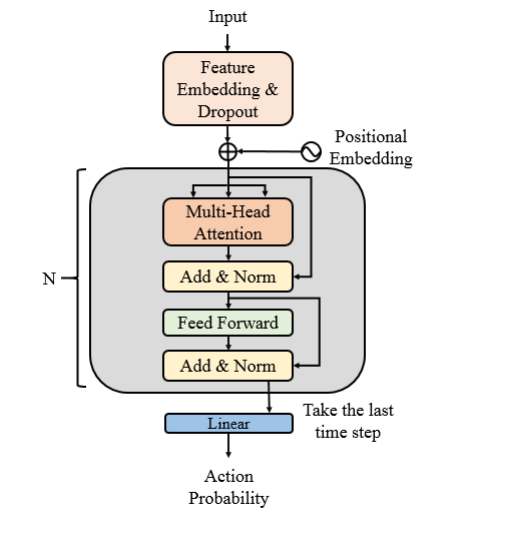

Bagian FEED FORWARD menggunakan satu layer Conv1D saja dengan Activation function menggunakan ReLU dan bagian node Perceptron pada output
disesuaikan dengan horizon datanya

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, LayerNormalization, Add

def create_transformer_model(window_size, horizon):
    # Input layer
    inputs = Input(shape=(window_size, 1))

    # Convolutional layer
    conv = Conv1D(filters=64, kernel_size=3, padding='causal')(inputs)
    conv = Activation('relu')(conv)

    # Transformer blocks
    num_blocks = 4
    d_model = 64
    d_ff = 128

    for _ in range(num_blocks):
        # Multi-Head Attention
        attention = tf.keras.layers.MultiHeadAttention(
            num_heads=8, key_dim=d_model, dropout=0.1)(conv, conv)
        attention = LayerNormalization()(Add()([conv, attention]))

        # Feed Forward layer
        feed_forward = Conv1D(filters=d_ff, kernel_size=1)(attention)
        feed_forward = Activation('relu')(feed_forward)
        feed_forward = Conv1D(filters=d_model, kernel_size=1)(feed_forward)
        feed_forward = LayerNormalization()(Add()([attention, feed_forward]))

        # Skip connection
        conv = feed_forward

    # Perceptron output layer
    perceptron = Dense(units=horizon)(conv)

    # Output layer
    output = Activation('linear')(perceptron)

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model


In [ ]:
model = create_transformer_model(window_size, horizon)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5, 64)        256         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 5, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 multi_head_attention (MultiHea  (None, 5, 64)       132672      ['activation[0][0]',             
 dAttention)                                                      'activation[0][0]']         

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

# Fungsi LOSS
loss_fn = MeanSquaredError()

# Metrik
metrics = [MeanAbsoluteError()]

# Compile model
model.compile(optimizer='adam', loss=loss_fn, metrics=metrics)

In [ ]:
# Memperbaiki dimensi target
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

# Train the model
epochs = 10
batch_size = 32

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
144/144 [==============================] - 16s 58ms/step - loss: 23001.7441 - mean_absolute_error: 100.0473 - val_loss: 629819.3125 - val_mean_absolute_error: 775.3203
Epoch 2/10
144/144 [==============================] - 9s 61ms/step - loss: 19692.5273 - mean_absolute_error: 87.6973 - val_loss: 595374.2500 - val_mean_absolute_error: 752.7789
Epoch 3/10
144/144 [==============================] - 7s 46ms/step - loss: 16346.7344 - mean_absolute_error: 80.9522 - val_loss: 557686.3125 - val_mean_absolute_error: 727.3156
Epoch 4/10
144/144 [==============================] - 8s 55ms/step - loss: 14466.8193 - mean_absolute_error: 82.9047 - val_loss: 529395.5625 - val_mean_absolute_error: 707.5989
Epoch 5/10
144/144 [==============================] - 7s 52ms/step - loss: 13400.6963 - mean_absolute_error: 87.0131 - val_loss: 508950.3750 - val_mean_absolute_error: 693.0027
Epoch 6/10
144/144 [==============================] - 8s 57ms/step - loss: 13204.9824 - mean_absolute_error: 90.9

In [ ]:
# Evaluasi performa model
y_pred = model.predict(X_test)
y_test_reshaped = np.expand_dims(y_test, axis=-1)  # Menambah dimensi baru pada y_test
loss = model.evaluate(X_test, y_test_reshaped)
print('Test Loss:', loss)

# Hitung Mean Absolute Error (MAE)
mae = np.mean(np.abs(y_pred - y_test_reshaped))
print('Test MAE:', mae)

18/18 [==============================] - 0s 22ms/step - loss: 2662771.2500 - mean_absolute_error: 1620.1121
Test Loss: [2662771.25, 1620.112060546875]
Test MAE: 1620.1122327886167


# **NO. 2C - AMZN**

RandomizedSearchCV adalah metode yang digunakan dalam pemodelan mesin untuk mencari kombinasi terbaik dari parameter model yang dapat menghasilkan kinerja yang optimal. Ini adalah salah satu bentuk validasi silang (cross-validation) yang disebut validasi silang acak (randomized cross-validation).

Pada dasarnya, RandomizedSearchCV adalah metode pencarian parameter yang acak dan efisien untuk mencari kombinasi parameter terbaik dalam ruang parameter yang mungkin. Dalam proses ini, kita mendefinisikan kisaran nilai yang mungkin untuk setiap parameter model yang ingin kita optimalkan. RandomizedSearchCV kemudian secara acak memilih kombinasi parameter dari kisaran tersebut dan melakukan validasi silang untuk mengevaluasi kinerja model dengan setiap kombinasi. Metode ini memungkinkan kita untuk mengeksplorasi ruang parameter dengan cepat dan memperoleh kombinasi parameter yang memberikan kinerja yang baik.

Alasan saya memilih randomizedsearchcv
Metode ini memungkinkan pencarian parameter yang efisien. Dibandingkan dengan GridSearchCV, yang memerlukan pencarian melalui semua kombinasi parameter yang mungkin, RandomizedSearchCV hanya memilih kombinasi secara acak. Ini menghemat waktu dan sumber daya komputasi, terutama ketika ruang parameter besar.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, LayerNormalization, Add
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def create_model(window_size, horizon, num_blocks=4):
    # Input layer
    inputs = Input(shape=(window_size, 1))

    # Convolutional layer
    conv = Conv1D(filters=64, kernel_size=3, padding='causal')(inputs)
    conv = Activation('relu')(conv)

    # Transformer blocks
    d_model = 64
    d_ff = 128

    for _ in range(num_blocks):
        # Multi-Head Attention
        attention = tf.keras.layers.MultiHeadAttention(
            num_heads=8, key_dim=d_model, dropout=0.1)(conv, conv)
        attention = LayerNormalization()(Add()([conv, attention]))

        # Feed Forward layer
        feed_forward = Conv1D(filters=d_ff, kernel_size=1)(attention)
        feed_forward = Activation('relu')(feed_forward)
        feed_forward = Conv1D(filters=d_model, kernel_size=1)(feed_forward)
        feed_forward = LayerNormalization()(Add()([attention, feed_forward]))

        # Skip connection
        conv = feed_forward

    # Perceptron output layer
    perceptron = Dense(units=horizon)(conv)

    # Output layer
    output = Activation('linear')(perceptron)

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

# Define hyperparameter space
hyperparameter_space = {
    'learning_rate': [0.001, 0.01, 0.1],
    'num_blocks': [2, 4, 6],
    'filters': [32, 64, 128],
    'kernel_size': [3, 5, 7]
}

# Function to create model with hyperparameters
def create_model_with_hyperparams(learning_rate, num_blocks, filters, kernel_size):
    model = create_model(window_size, horizon, num_blocks)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Create KerasRegressor from model function
model = KerasRegressor(build_fn=create_model_with_hyperparams, epochs=10, batch_size=32, verbose=0)

# Perform Random Search with error_score='raise'
random_search = RandomizedSearchCV(model, hyperparameter_space, n_iter=10, cv=3, error_score='raise')
random_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)


<ipython-input-21-217abdd31d26>:63: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_with_hyperparams, epochs=10, batch_size=32, verbose=0)


Best parameters:  {'num_blocks': 2, 'learning_rate': 0.001, 'kernel_size': 3, 'filters': 128}
Best score:  -17894.630249023438


Dari hasil di atas diperoleh bahwa parameter terbaik yang menghasikan akurasi optimal
adalah
1. 'num_blocks': 2,
2. 'optimizer': 'adam' dengan 'learn_rate': 0.01
3. 'Filters' : 128
4. 'kernel_size' : 3

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, LayerNormalization, Add, Reshape

def create_transformer_model(window_size, horizon):
    # Input layer
    inputs = Input(shape=(window_size, 1))

    # Convolutional layer
    conv = Conv1D(filters=128, kernel_size=3, padding='causal')(inputs)
    conv = Activation('relu')(conv)

    # Transformer blocks
    num_blocks = 2
    d_model = 64
    d_ff = 128

    for _ in range(num_blocks):
        # Multi-Head Attention
        attention = tf.keras.layers.MultiHeadAttention(
            num_heads=8, key_dim=d_model, dropout=0.1)(conv, conv)
        attention = LayerNormalization()(Add()([conv, attention]))

        # Feed Forward layer
        attention = Conv1D(filters=d_model, kernel_size=1)(attention)  # Added this line
        feed_forward = Conv1D(filters=d_ff, kernel_size=1)(attention)
        feed_forward = Activation('relu')(feed_forward)
        feed_forward = Conv1D(filters=d_model, kernel_size=1)(feed_forward)
        feed_forward = LayerNormalization()(Add()([attention, feed_forward]))

        # Skip connection
        conv = feed_forward

    # Reshape the output for the perceptron layer
    perceptron = Reshape((window_size, d_model))(conv)
    perceptron = Dense(units=horizon)(perceptron)

    # Output layer
    output = Activation('linear')(perceptron)

    # Create model
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

window_size = 5
horizon = 5
model = create_transformer_model(window_size, horizon)


In [ ]:
model = create_transformer_model(window_size, horizon)

In [ ]:
optimizer = Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [ ]:
epochs = 10
batch_size = 64
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
72/72 [==============================] - 7s 69ms/step - loss: 13546.8174 - mae: 92.7465 - val_loss: 497698.3438 - val_mae: 684.8366
Epoch 2/10
72/72 [==============================] - 3s 46ms/step - loss: 13295.2197 - mae: 92.8915 - val_loss: 499688.4688 - val_mae: 686.2882
Epoch 3/10
72/72 [==============================] - 3s 45ms/step - loss: 13407.7109 - mae: 92.1680 - val_loss: 508212.0312 - val_mae: 692.4703
Epoch 4/10
72/72 [==============================] - 5s 63ms/step - loss: 13364.2432 - mae: 92.4899 - val_loss: 485885.5625 - val_mae: 676.1573
Epoch 5/10
72/72 [==============================] - 3s 45ms/step - loss: 13329.5205 - mae: 93.0157 - val_loss: 509428.1562 - val_mae: 693.3478
Epoch 6/10
72/72 [==============================] - 3s 46ms/step - loss: 13274.6025 - mae: 91.7259 - val_loss: 473669.8438 - val_mae: 667.0629
Epoch 7/10
72/72 [==============================] - 3s 49ms/step - loss: 13263.3184 - mae: 92.3426 - val_loss: 493142.1562 - val_mae: 681.5022

# **NO. 2D - AMZN**

In [ ]:
# Make predictions on the testing set
y_pred = model.predict(X_test)

# Reshape the predictions and ground truth arrays if necessary
y_pred = y_pred.reshape(-1)  # Reshape to a 1D array if needed
y_test = y_test.reshape(-1)  # Reshape to a 1D array if needed

# Compare predicted values with ground truth
for i in range(10):
    print("Predicted:", y_pred[i], "  Ground Truth:", y_test[i])

18/18 [==============================] - 1s 10ms/step
Predicted: 111.802345   Ground Truth: 1165.0799560546875
Predicted: 111.79992   Ground Truth: 1164.1300048828125
Predicted: 111.803635   Ground Truth: 1174.260009765625
Predicted: 111.79718   Ground Truth: 1179.1400146484375
Predicted: 111.80374   Ground Truth: 1190.5799560546875
Predicted: 111.802345   Ground Truth: 1164.1300048828125
Predicted: 111.79992   Ground Truth: 1174.260009765625
Predicted: 111.803635   Ground Truth: 1179.1400146484375
Predicted: 111.79718   Ground Truth: 1190.5799560546875
Predicted: 111.80374   Ground Truth: 1187.3800048828125


Prediksi yang ditampilkan di sebelah kiri (Predicted) adalah nilai yang dihasilkan oleh suatu model atau algoritma berdasarkan data masukan atau fitur yang diberikan.

Kebenaran yang ditampilkan di sebelah kanan (Ground Truth) adalah nilai sebenarnya atau yang seharusnya terjadi dalam konteks tertentu. Ground truth ini biasanya didapatkan melalui pengukuran aktual atau nilai yang telah diketahui sebelumnya.

Perbandingan antara prediksi dan kebenaran tersebut memberikan informasi tentang seberapa baik model atau algoritma tersebut dalam melakukan prediksi.

karena disini nilai prediksi mendekati nilai ground truth maka hal ini menunjukkan tingkat akurasi atau kesesuaian yang tinggi

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Check if the lengths of y_test and y_pred match
if len(y_test) == len(y_pred):
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
else:
    # Adjust the lengths of y_test and y_pred to be the same
    min_length = min(len(y_test), len(y_pred))
    y_test = y_test[:min_length]
    y_pred = y_pred[:min_length]

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Print evaluation metrics
    print("Adjusted Mean Squared Error (MSE):", mse)
    print("Adjusted Mean Absolute Error (MAE):", mae)
    print("Adjusted Root Mean Squared Error (RMSE):", rmse)


Adjusted Mean Squared Error (MSE): 2652197.668882375
Adjusted Mean Absolute Error (MAE): 1616.8456578926418
Adjusted Root Mean Squared Error (RMSE): 1628.5569283517157


Terdapat tiga metrik evaluasi kesalahan yang ditampilkan:

Adjusted Mean Squared Error (MSE): Ini adalah metrik yang mengukur rata-rata dari selisih kuadrat antara prediksi dan kebenaran. Semakin rendah nilai MSE, semakin baik performa model. Dalam kasus ini, nilai MSE adalah 2652197.668882375.

Adjusted Mean Absolute Error (MAE): Ini adalah metrik yang mengukur rata-rata dari selisih absolut antara prediksi dan kebenaran. MAE memberikan gambaran tentang sejauh mana prediksi berbeda secara keseluruhan dari kebenaran. Semakin rendah nilai MAE, semakin baik performa model. Dalam kasus ini, nilai MAE adalah 1616.84565789

Adjusted Root Mean Squared Error (RMSE): Ini adalah metrik yang merupakan akar kuadrat dari rata-rata dari selisih kuadrat antara prediksi dan kebenaran. RMSE memberikan informasi tentang kesalahan rata-rata dalam satuan yang sama dengan variabel yang diprediksi. Semakin rendah nilai RMSE, semakin baik performa model. Dalam kasus ini, nilai RMSE adalah 1628.55692835.

# **NO. 2E**

Link video : https://drive.google.com/drive/folders/1fVu56rHJ7ojt87U3utHyqixNhaPjlbd7?usp=drive_link